<a href="https://colab.research.google.com/github/mohamedsto7y/FASTai/blob/main/ClassifiySyndromes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I am getting the imports

In [1]:
from google.colab import drive

!pip install -Uqq fastbook
import fastbook
import os
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
key = os.environ.get('AZURE_SEARCH_KEY', '360f00a84c3d4c4a92b34e6dd52e1dc9')
search_images_bing


     |████████████████████████████████| 727kB 20.8MB/s 
     |████████████████████████████████| 1.1MB 53.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 194kB 54.4MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
Mounted at /content/gdrive


<function fastbook.search_images_bing>

Searching with bing API,I make directory for the two syndromes with a class for each one

In [2]:
syndrome_types = 'turner syndrome','klinefelter syndrome'
path = Path('syndrome')
if not path.exists():
    path.mkdir()
    for o in syndrome_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} real person')
        download_images(dest, urls=results.attrgot('contentUrl'))

Loading the images and removing the broken ones


In [3]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

In [4]:
syndrome = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


In [5]:
syndrome = syndrome.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
syndrome = syndrome.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = syndrome.dataloaders(path)


In [6]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.210895,0.826775,0.320755,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.821168,0.815510,0.358491,00:04
1,0.801848,0.878430,0.396226,00:04
2,0.741545,0.872414,0.320755,00:04
3,0.659011,0.908879,0.320755,00:04
4,0.576753,0.952814,0.320755,00:04
5,0.524015,1.012995,0.301887,00:04
6,0.475347,1.038627,0.301887,00:04
7,0.454500,1.066323,0.301887,00:04


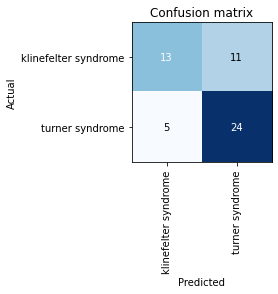

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [8]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [9]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()



In [12]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab


['klinefelter syndrome', 'turner syndrome']

In [15]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload




FileUpload(value={}, description='Upload')

In [21]:
img = PILImage.create(btn_upload.data[-1])

In [22]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [23]:
pred,pred_idx,probs = learn_inf.predict(img)

In [24]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: klinefelter syndrome; Probability: 0.5285')

In [25]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [26]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [28]:
btn_upload = widgets.FileUpload()


In [29]:
#hide_output
VBox([widgets.Label('Select the Syndrome!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [30]:
VBox([widgets.Label('Select the Syndrome!'), 
      btn_upload, btn_run, out_pl, lbl_pred])